<a href="https://colab.research.google.com/github/FinnRobertson15/PatternAnalysis-2023/blob/topic-recognition/Colab%20version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%cd

/root


In [ ]:
import zipfile
import os

# Define the paths
zip_path = '/content/drive/MyDrive/AD_NC.zip'  # Path to the zip file
extract_path = '/content/extracted_folder'  # Path where you want to extract the contents

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the contents of the extracted folder
extracted_files = os.listdir(extract_path)
print(extracted_files)

['AD_NC']


In [ ]:
cd /content/extracted_folder/AD_NC

/content/extracted_folder/AD_NC


In [ ]:
ls

test/  train/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import time
import numpy as np
# import pandas as pd
import math
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset
import random
import matplotlib.pyplot as plt

In [ ]:
batch_size = 128

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

class SiameseDataset(Dataset):
    def __init__(self, AD, NC):
        # Combine the datasets and labels
        self.X = AD + NC

        self.Y = torch.cat((torch.ones(len(AD)), torch.zeros(len(NC))), dim=0)

        # Generate a random permutation of indices
        self.i_indices = torch.randperm(len(self.X) // 2)
        self.j_indices = torch.randperm(len(self.X) // 2)


    def __len__(self):
        return len(self.X) // 2

    def __getitem__(self, idx):
        i = self.i_indices[idx] * 2
        j = self.j_indices[idx] * 2 + 1
        img1 = self.X[i]
        img2 = self.X[j]
        l1 = self.Y[i]
        l2 = self.Y[j]

        return img1, img2, l1, l2

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


size = 64

def intensity_normalization(img):
    mean = torch.mean(img)
    std = torch.std(img)
    return (img - mean) / std

def windowing(img, window_center, window_width):
    img = torch.clamp(img, window_center - window_width // 2, window_center + window_width // 2)
    img = (img - (window_center - 0.5)) / (window_width - 1)
    return img

# Example usage in your transform
transform_X = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Lambda(intensity_normalization),
    transforms.Lambda(lambda x: windowing(x, window_center=size // 2, window_width=size))
])


# Replace 'your_nii_folder' with the path to your folder containing .nii files
# nii_dataset = NiiDataset(root_dir=r'keras_png_slices_data\keras_png_slices_data\keras_png_slices_train')
loaders = {}

for stage in ['test']:
    loaders[stage] = {}
    AD = CustomDataset(root_dir=os.path.join(stage, 'AD'), transform=transform_X)
    NC = CustomDataset(root_dir=os.path.join(stage, 'NC'), transform=transform_X)
    dataset = SiameseDataset(AD, NC)
    loaders[stage] = DataLoader(dataset, batch_size=batch_size)

In [ ]:
count = 0
same = 0
for i, j, n, m in loaders['test']:
  count += len(n)
  same += (n == m).sum().tolist()
same / count

0.5144444444444445

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class SiameseNetwork(nn.Module):
    def __init__(self, pretrained=True):
        super(SiameseNetwork, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        # Modify the first convolution layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc1 = nn.Linear(1000, 500)  # Customize the fully connected layers
        self.fc2 = nn.Linear(500, 2)  # Customize the fully connected layers

    def forward(self, x1, x2):
        output1 = self.resnet(x1)
        output2 = self.resnet(x2)
        output = torch.abs(output1 - output2)
        output = self.fc1(output)
        output = self.fc2(output)
        return output

model = SiameseNetwork()

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [ ]:
# Initialize the network, loss function, and optimizer
siamese_net = SiameseNetwork(pretrained=True).to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)
# Training loop
epochs = 5
total_step = len(loaders['test'])
for epoch in range(epochs):
  for i, (img1, img2, lab1, lab2) in enumerate(loaders['test']):
    img1, img2, lab1, lab2 = img1.to(device), img2.to(device), lab1.to(device), lab2.to(device)
    output = siamese_net(img1, img2)
    o1, o2 = output[:, 0], output[:, 1]
    label = (lab1 == lab2).int()

    loss = criterion(o1, o2, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % 21 == 0:
      print((lab1[0], lab2[0]))
      print(label[0])
      print(output[0])
      print(f"Epoch [{epoch + 1} / {epochs}], Step [{i + 1} / {total_step} Loss {loss.item()}]")

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))
tensor(0, device='cuda:0', dtype=torch.int32)
tensor([ 0.0997, -0.0306], device='cuda:0', grad_fn=<SelectBackward0>)
Epoch [1 / 5], Step [21 / 141 Loss 0.9753031730651855]
(tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))
tensor(1, device='cuda:0', dtype=torch.int32)
tensor([ 0.1081, -0.0379], device='cuda:0', grad_fn=<SelectBackward0>)
Epoch [1 / 5], Step [42 / 141 Loss 1.025275707244873]
(tensor(1., device='cuda:0'), tensor(0., device='cuda:0'))
tensor(0, device='cuda:0', dtype=torch.int32)
tensor([ 0.0929, -0.0268], device='cuda:0', grad_fn=<SelectBackward0>)
Epoch [1 / 5], Step [63 / 141 Loss 0.9390543699264526]
(tensor(1., device='cuda:0'), tensor(0., device='cuda:0'))
tensor(0, device='cuda:0', dtype=torch.int32)
tensor([ 0.1265, -0.0541], device='cuda:0', grad_fn=<SelectBackward0>)
Epoch [1 / 5], Step [84 / 141 Loss 1.0038050413131714]
(tensor(1., device='cuda:0'), tensor(0., device='cuda:0'))
tensor(0, device='

In [ ]:
correct = 0
total = 0
features = []
labels = []
with torch.no_grad():
    for i, (img1, img2, lab1, lab2) in enumerate(loaders['test']):
        img1, img2, lab1, lab2 = img1.to(device), img2.to(device), lab1.to(device), lab2.to(device)
        output = siamese_net(img1, img2)
        out1, out2 = output[:, 0], output[:, 1]
        predicted = (out1 - out2).pow(2).sum().sqrt().lt(0.5)
        total += lab1.size(0)
        correct += (predicted == lab1).sum().item()
        features.extend(out1.tolist())
        labels.extend(lab1.tolist())
        features.extend(out2.tolist())
        labels.extend(lab2.tolist())


    print(f'Accuracy of the network on the test images: {100 * correct / total}%')


Accuracy of the network on the test images: 49.955555555555556%


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(features).reshape(-1, 1), labels, test_size=0.2, random_state=42)

# Train a logistic regression model
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.49166666666666664


In [ ]:
features[0].tolist()

0.5943959355354309

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 96
from torch.utils.data.dataset import Subset, random_split

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

class TripletDataset(Dataset):
    def __init__(self, AD, NC, transform=None):
        self.X = AD + NC
        self.AD = AD
        self.NC = NC
        self.Y = torch.cat((torch.ones(len(AD)), torch.zeros(len(NC))), dim=0)
        self.anc_indices = torch.randperm(len(self.X))
        self.pos_indices = torch.randperm(len(self.X)) % len(AD)
        self.neg_indices = torch.randperm(len(self.X)) % len(NC)
        self.transform = transform

    def __len__(self):
        return len(self.anc_indices)

    def __getitem__(self, idx):
        anc = self.anc_indices[idx]
        pos = self.pos_indices[idx]
        neg = self.neg_indices[idx]
        img1 = self.X[anc]
        img2 = self.AD[pos]
        img3 = self.NC[neg]
        label = self.Y[anc]

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        return img1, img2, img3, label


size = 128

def intensity_normalization(img, mean = None, std = None):
    mean = torch.mean(img)
    std = torch.std(img)
    return (img - mean) / std

class CustomNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        return (img - self.mean) / self.std

transform_train = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Random affine transformations with smaller parameters
    transforms.Lambda(intensity_normalization)
])

transform_test = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Lambda(intensity_normalization)
])

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        return (img - self.mean) / self.std



# Replace 'your_nii_folder' with the path to your folder containing .nii files
# nii_dataset = NiiDataset(root_dir=r'keras_png_slices_data\keras_png_slices_data\keras_png_slices_train')
loaders = {}
AD_train = CustomDataset(root_dir=os.path.join('train', 'AD'), transform=transform_train)
NC_train = CustomDataset(root_dir=os.path.join('train', 'NC'), transform=transform_train)

X = torch.stack([img for img in AD_train + NC_train])
mean = X.mean()
std = X.std()
normalize = transforms.Compose([
        Normalize(mean, std)
    ])
train_dataset = TripletDataset(AD_train, NC_train, normalize)


# Create data loaders for training and validation data
loaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

AD_test = CustomDataset(root_dir=os.path.join('test', 'AD'), transform=transform_test)
NC_test = CustomDataset(root_dir=os.path.join('test', 'NC'), transform=transform_test)

test_dataset = TripletDataset(AD_test, NC_test, normalize)

split_1 = int(0.5 * len(test_dataset))
split_2 = len(test_dataset) - split_1

# Perform the split
test_dataset, cal_dataset = random_split(test_dataset, [split_1, split_2])

loaders['cal'] = DataLoader(cal_dataset, batch_size=batch_size, shuffle=True)
loaders['test'] = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_dataset), len(cal_dataset), len(test_dataset)

(21520, 4500, 4500)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class TripletSiameseNetwork(nn.Module):
    def __init__(self, pretrained=True):
        super(TripletSiameseNetwork, self).__init__()
        self.resnet = models.resnet18(pretrained=pretrained)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc1 = nn.Linear(1000, 32)
        # self.fc2 = nn.Linear(500, 32)

    def forward_once(self, x):
        output = self.resnet(x)
        output = self.fc1(output)
        # output = self.fc2(output)
        return output

    def forward(self, anchor, positive, negative):
        output_anchor = self.forward_once(anchor)
        output_positive = self.forward_once(positive)
        output_negative = self.forward_once(negative)
        return output_anchor, output_positive, output_negative

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

class TripletLossWithRegularization(nn.Module):
    def __init__(self, margin=1.0, lambda_reg=0.0001):
        super(TripletLossWithRegularization, self).__init__()
        self.margin = margin
        self.lambda_reg = lambda_reg  # Regularization parameter

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        triplet_losses = F.relu(distance_positive - distance_negative + self.margin)
        triplet_loss = triplet_losses.mean()

        # Compute L2 regularization
        l2_reg = None
        for param in trip_model.parameters():
            if l2_reg is None:
                l2_reg = param.norm(2)
            else:
                l2_reg = l2_reg + param.norm(2)

        loss = triplet_loss + self.lambda_reg * l2_reg
        return loss





In [ ]:
from torch.optim.lr_scheduler import StepLR
learning_rate = 0.05
trip_model = TripletSiameseNetwork()
trip_criterion = TripletLossWithRegularization(margin=1.0)
val_criterion = TripletLoss(margin=1.0)
total_step = len(loaders['train'])

# optimizer = optim.Adam(trip_model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.8)
optimizer = torch.optim.SGD(trip_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

sched_linear_1 = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.005, max_lr=learning_rate, step_size_up=15, step_size_down=15, mode="triangular", verbose=False)
sched_linear_3 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.005/learning_rate, end_factor=0.005/learning_rate, verbose=False)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[sched_linear_1, sched_linear_3], milestones=[30])

Epoch [1 / 15], Step [22 / 225], Loss: 1.6861666440963745, Validation Loss: 1.3392752408981323
Epoch [1 / 15], Step [44 / 225], Loss: 1.1134928464889526, Validation Loss: 1.0987355709075928
Epoch [1 / 15], Step [66 / 225], Loss: 1.0257302522659302, Validation Loss: 1.1489994525909424
Epoch [1 / 15], Step [88 / 225], Loss: 1.1023128032684326, Validation Loss: 1.149999976158142
Epoch [1 / 15], Step [110 / 225], Loss: 0.794222354888916, Validation Loss: 1.2070260047912598
Epoch [1 / 15], Step [132 / 225], Loss: 0.9533556699752808, Validation Loss: 1.061461329460144
Epoch [1 / 15], Step [154 / 225], Loss: 0.5997182726860046, Validation Loss: 0.9921392202377319
Epoch [1 / 15], Step [176 / 225], Loss: 0.8227355480194092, Validation Loss: 0.8853449821472168
Epoch [1 / 15], Step [198 / 225], Loss: 1.0741984844207764, Validation Loss: 1.1926651000976562
Epoch [1 / 15], Step [220 / 225], Loss: 1.4481054544448853, Validation Loss: 1.1044371128082275


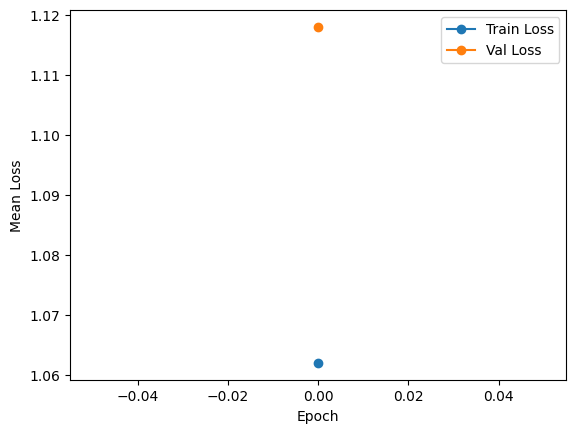

Epoch [2 / 15], Step [22 / 225], Loss: 0.993647038936615, Validation Loss: 0.9966787695884705
Epoch [2 / 15], Step [44 / 225], Loss: 1.0237594842910767, Validation Loss: 1.0309518575668335
Epoch [2 / 15], Step [66 / 225], Loss: 0.883934497833252, Validation Loss: 1.0600988864898682
Epoch [2 / 15], Step [88 / 225], Loss: 1.0512185096740723, Validation Loss: 0.8157957792282104
Epoch [2 / 15], Step [110 / 225], Loss: 0.7038865089416504, Validation Loss: 0.8065618276596069
Epoch [2 / 15], Step [132 / 225], Loss: 0.8788958191871643, Validation Loss: 0.9165557622909546
Epoch [2 / 15], Step [154 / 225], Loss: 0.5161008834838867, Validation Loss: 0.7060334086418152
Epoch [2 / 15], Step [176 / 225], Loss: 0.312076598405838, Validation Loss: 0.40925726294517517
Epoch [2 / 15], Step [198 / 225], Loss: 0.46442490816116333, Validation Loss: 0.510191798210144
Epoch [2 / 15], Step [220 / 225], Loss: 0.08432803303003311, Validation Loss: 0.13745912909507751


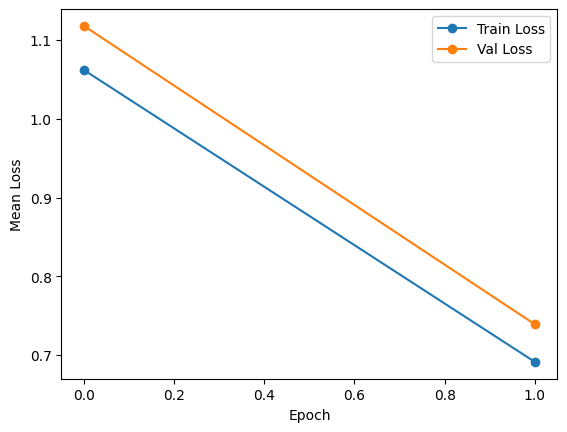

Epoch [3 / 15], Step [22 / 225], Loss: 0.6365734934806824, Validation Loss: 0.9633301496505737
Epoch [3 / 15], Step [44 / 225], Loss: 0.720203697681427, Validation Loss: 0.2848336696624756
Epoch [3 / 15], Step [66 / 225], Loss: 0.061845649033784866, Validation Loss: 0.9537119269371033
Epoch [3 / 15], Step [88 / 225], Loss: 0.09502657502889633, Validation Loss: 0.17387674748897552
Epoch [3 / 15], Step [110 / 225], Loss: 0.16061733663082123, Validation Loss: 0.0026112645864486694
Epoch [3 / 15], Step [132 / 225], Loss: 0.1448567658662796, Validation Loss: 0.176682710647583
Epoch [3 / 15], Step [154 / 225], Loss: 0.11984804272651672, Validation Loss: 0.0029973338823765516
Epoch [3 / 15], Step [176 / 225], Loss: 0.05067078024148941, Validation Loss: 0.024889525026082993
Epoch [3 / 15], Step [198 / 225], Loss: 0.08953560888767242, Validation Loss: 0.014550979249179363
Epoch [3 / 15], Step [220 / 225], Loss: 0.05057196691632271, Validation Loss: 0.14682522416114807


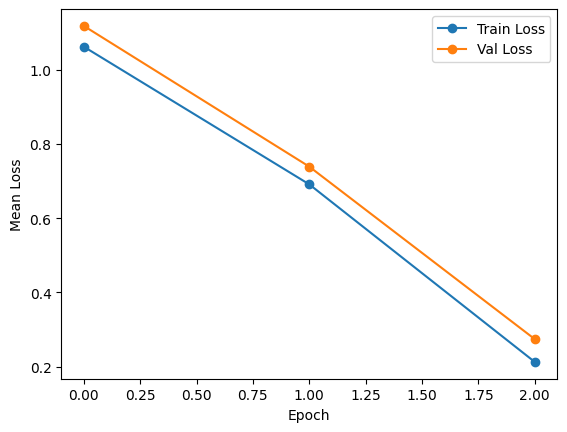

Epoch [4 / 15], Step [22 / 225], Loss: 0.05052595213055611, Validation Loss: 0.2758115828037262
Epoch [4 / 15], Step [44 / 225], Loss: 0.26822781562805176, Validation Loss: 0.33429664373397827
Epoch [4 / 15], Step [66 / 225], Loss: 0.05043775588274002, Validation Loss: 0.04388421028852463
Epoch [4 / 15], Step [88 / 225], Loss: 0.05038832128047943, Validation Loss: 0.06882896274328232
Epoch [4 / 15], Step [110 / 225], Loss: 0.05032651126384735, Validation Loss: 0.015540232881903648
Epoch [4 / 15], Step [132 / 225], Loss: 0.05026824027299881, Validation Loss: 0.9465289115905762
Epoch [4 / 15], Step [154 / 225], Loss: 0.08250364661216736, Validation Loss: 0.0
Epoch [4 / 15], Step [176 / 225], Loss: 0.07428855448961258, Validation Loss: 0.046117693185806274
Epoch [4 / 15], Step [198 / 225], Loss: 0.05011678487062454, Validation Loss: 0.022663306444883347
Epoch [4 / 15], Step [220 / 225], Loss: 0.05006015673279762, Validation Loss: 0.015940412878990173


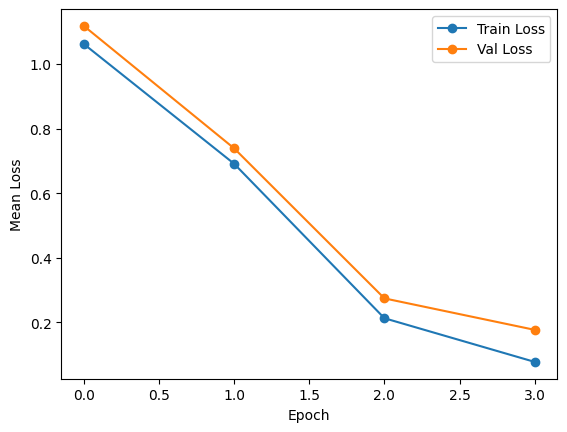

Epoch [5 / 15], Step [22 / 225], Loss: 0.04997241497039795, Validation Loss: 0.0
Epoch [5 / 15], Step [44 / 225], Loss: 0.049897659569978714, Validation Loss: 0.0223587267100811
Epoch [5 / 15], Step [66 / 225], Loss: 0.049830615520477295, Validation Loss: 0.0
Epoch [5 / 15], Step [88 / 225], Loss: 0.049757134169340134, Validation Loss: 0.0
Epoch [5 / 15], Step [110 / 225], Loss: 0.0496828556060791, Validation Loss: 0.04544451832771301
Epoch [5 / 15], Step [132 / 225], Loss: 0.049610793590545654, Validation Loss: 0.0
Epoch [5 / 15], Step [154 / 225], Loss: 0.04953967407345772, Validation Loss: 0.010974577628076077
Epoch [5 / 15], Step [176 / 225], Loss: 0.049466632306575775, Validation Loss: 0.0
Epoch [5 / 15], Step [198 / 225], Loss: 0.04939447343349457, Validation Loss: 0.020791243761777878
Epoch [5 / 15], Step [220 / 225], Loss: 0.04932032525539398, Validation Loss: 0.0


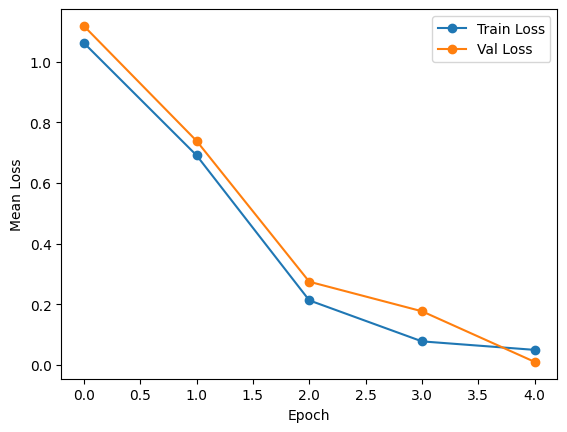

Epoch [6 / 15], Step [22 / 225], Loss: 0.30001387000083923, Validation Loss: 0.0
Epoch [6 / 15], Step [44 / 225], Loss: 0.049207571893930435, Validation Loss: 0.015120014548301697
Epoch [6 / 15], Step [66 / 225], Loss: 0.04912778362631798, Validation Loss: 0.007269968744367361
Epoch [6 / 15], Step [88 / 225], Loss: 0.04904578626155853, Validation Loss: 0.0
Epoch [6 / 15], Step [110 / 225], Loss: 1.0179965496063232, Validation Loss: 1.0021252632141113
Epoch [6 / 15], Step [132 / 225], Loss: 0.9388081431388855, Validation Loss: 0.9330480098724365
Epoch [6 / 15], Step [154 / 225], Loss: 0.8098025321960449, Validation Loss: 0.4797901511192322
Epoch [6 / 15], Step [176 / 225], Loss: 0.15214264392852783, Validation Loss: 0.6066851019859314
Epoch [6 / 15], Step [198 / 225], Loss: 0.25942176580429077, Validation Loss: 0.0
Epoch [6 / 15], Step [220 / 225], Loss: 0.04873622953891754, Validation Loss: 0.02330446057021618


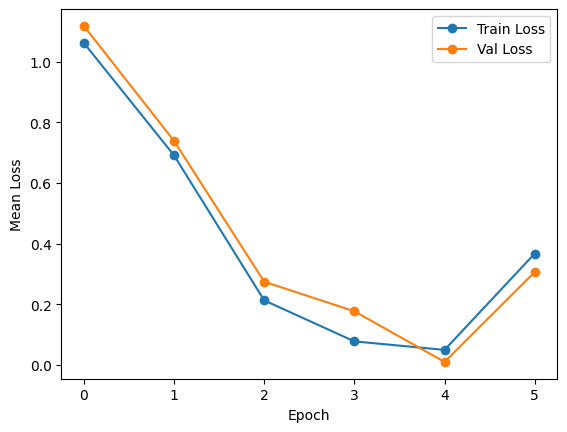

Epoch [7 / 15], Step [22 / 225], Loss: 0.04863778129220009, Validation Loss: 0.0
Epoch [7 / 15], Step [44 / 225], Loss: 0.09685459733009338, Validation Loss: 0.18659985065460205
Epoch [7 / 15], Step [66 / 225], Loss: 0.08631588518619537, Validation Loss: 1.3988771438598633
Epoch [7 / 15], Step [88 / 225], Loss: 0.6523657441139221, Validation Loss: 0.6873682737350464
Epoch [7 / 15], Step [110 / 225], Loss: 0.07394303381443024, Validation Loss: 0.03567586466670036
Epoch [7 / 15], Step [132 / 225], Loss: 0.048379410058259964, Validation Loss: 0.0
Epoch [7 / 15], Step [154 / 225], Loss: 0.04830015450716019, Validation Loss: 0.024945590645074844
Epoch [7 / 15], Step [176 / 225], Loss: 0.04822903499007225, Validation Loss: 0.0
Epoch [7 / 15], Step [198 / 225], Loss: 0.04814707115292549, Validation Loss: 0.0
Epoch [7 / 15], Step [220 / 225], Loss: 0.04806003347039223, Validation Loss: 0.0


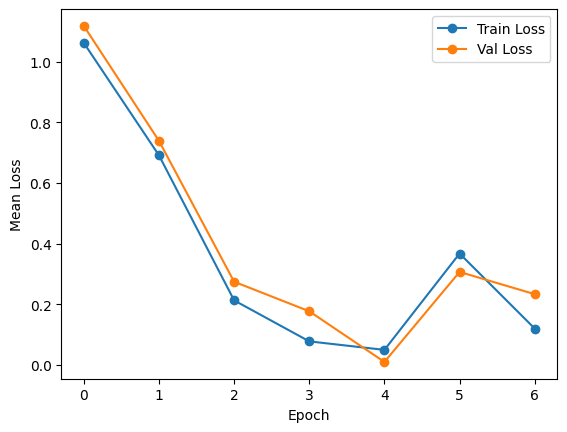

Epoch [8 / 15], Step [22 / 225], Loss: 0.04794354736804962, Validation Loss: 0.0
Epoch [8 / 15], Step [44 / 225], Loss: 0.04784921184182167, Validation Loss: 0.0


KeyboardInterrupt: ignored

In [64]:
from itertools import cycle

test_iter = cycle(iter(loaders['test']))
# Training loop
epochs = 15
trip_model.to(device)
losses = []
val_losses = []

transform_train = transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05))

for epoch in range(epochs):
  losses.append([])
  val_losses.append([])
  for i, (img1, img2, img3, _) in enumerate(loaders['train']):
    size = img1.size(0)
    img1, img2, img3 = img1[torch.randperm(size)], img2[torch.randperm(size)], img3[torch.randperm(size)]
    img1 = transform_train(img1)
    img2 = transform_train(img2)
    img3 = transform_train(img3)
    img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)


    out1, out2, out3 = trip_model(img1, img2, img3)

    loss = trip_criterion(out1, out2, out3)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses[epoch].append(loss.item())
    if (i + 1) % (total_step // 10) == 0:

      with torch.no_grad():
        val_img1, val_img2, val_img3, _ = next(test_iter)
        val_img1, val_img2, val_img3 = val_img1.to(device), val_img2.to(device), val_img3.to(device)
        val_out1, val_out2, val_out3 = trip_model(val_img1, val_img2, val_img3)
        val_loss = val_criterion(val_out1, val_out2, val_out3)
        val_losses[epoch].append(val_loss.item())

        print(f"Epoch [{epoch + 1} / {epochs}], Step [{i + 1} / {total_step}], Loss: {np.mean(losses[epoch])}, Validation Loss: {np.mean(val_losses[epoch])}")

  scheduler.step()
  # Calculate mean of each row
  mean_list1 = np.mean(losses, axis=1)
  mean_list2 = np.mean(val_losses, axis=1)

  # Plot the means
  plt.plot(mean_list1, label='Train Loss', marker='o')
  plt.plot(mean_list2, label='Val Loss', marker='o')

  plt.xlabel('Epoch')
  plt.ylabel('Mean Loss')
  plt.legend()
  plt.show()

In [ ]:
# data = {}
# labels = {}
trip_model.eval()
with torch.no_grad():
  embeddings = trip_model.forward_once
  for stage in ['train', 'cal', 'test']:
    data[stage] = []
    labels[stage] = []
    for i, (img1, _, _, label) in enumerate(loaders[stage]):
      img1 = img1.to(device)
      output = embeddings(img1)
      data[stage].extend(output.cpu().tolist())
      labels[stage].extend(label.tolist())

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

# Train a logistic regression model
classifier = LogisticRegression(max_iter=1000)
classifier.fit(data['cal'], labels['cal'])

# Make predictions
cal_predictions = classifier.predict(data['cal'])
val_predictions = classifier.predict(data['test'])

# Calculate accuracy
cal_accuracy = accuracy_score(labels['cal'], cal_predictions)
val_accuracy = accuracy_score(labels['test'], val_predictions)
print(f"Cal Accuracy: {cal_accuracy}")
print(f"Val Accuracy: {val_accuracy}")


Cal Accuracy: 0.7344444444444445
Val Accuracy: 0.7146666666666667
